##  Modules

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

##  Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!unzip '/content/drive/MyDrive/UTKFace.zip'

Streaming output truncated to the last 5000 lines.
  inflating: UTKFace/52_0_3_20170113184200775.jpg.chip.jpg  
  inflating: UTKFace/52_0_3_20170113190623929.jpg.chip.jpg  
  inflating: UTKFace/52_0_3_20170117190840617.jpg.chip.jpg  
  inflating: UTKFace/52_0_3_20170119160357804.jpg.chip.jpg  
  inflating: UTKFace/52_0_3_20170119181010188.jpg.chip.jpg  
  inflating: UTKFace/52_0_3_20170119200211340.jpg.chip.jpg  
  inflating: UTKFace/52_0_3_20170119200241996.jpg.chip.jpg  
  inflating: UTKFace/52_0_3_20170119200259595.jpg.chip.jpg  
  inflating: UTKFace/52_0_3_20170119200407188.jpg.chip.jpg  
  inflating: UTKFace/52_0_3_20170119204331863.jpg.chip.jpg  
  inflating: UTKFace/52_0_3_20170119204337838.jpg.chip.jpg  
  inflating: UTKFace/52_0_3_20170119205638160.jpg.chip.jpg  
  inflating: UTKFace/52_0_3_20170119205639336.jpg.chip.jpg  
  inflating: UTKFace/52_0_3_20170119205641007.jpg.chip.jpg  
  inflating: UTKFace/52_0_3_20170119205647136.jpg.chip.jpg  
  inflating: UTKFace/52_0_3_201701

In [4]:
BASE_DIR = '/content/UTKFace'

In [5]:
# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [6]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

image  age  gender
0  /content/UTKFace/50_0_0_20170117135739223.jpg....   50       0
1  /content/UTKFace/12_0_0_20170110225348936.jpg....   12       0
2  /content/UTKFace/40_1_0_20170117150751092.jpg....   40       1
3  /content/UTKFace/22_1_2_20170116172549492.jpg....   22       1
4  /content/UTKFace/88_1_0_20170120134913783.jpg....   88       1

In [7]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

## Exploratory Data Analysis

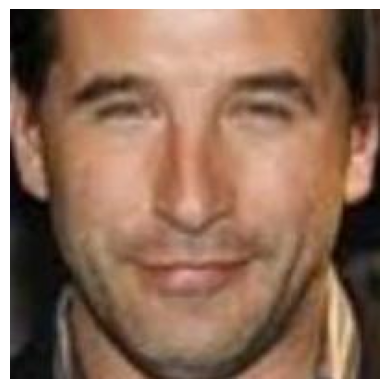

In [8]:
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);

<Axes: xlabel='age', ylabel='Density'>

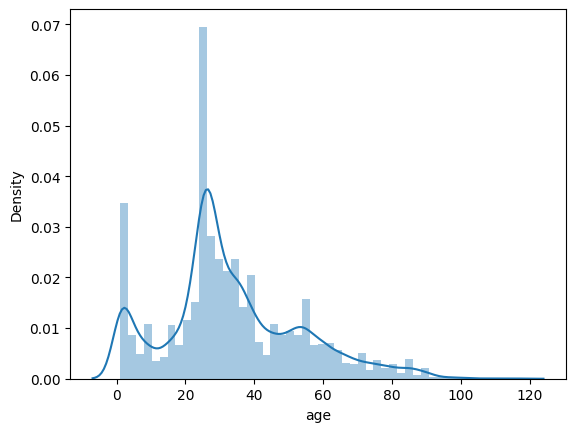

In [9]:
sns.distplot(df['age'])

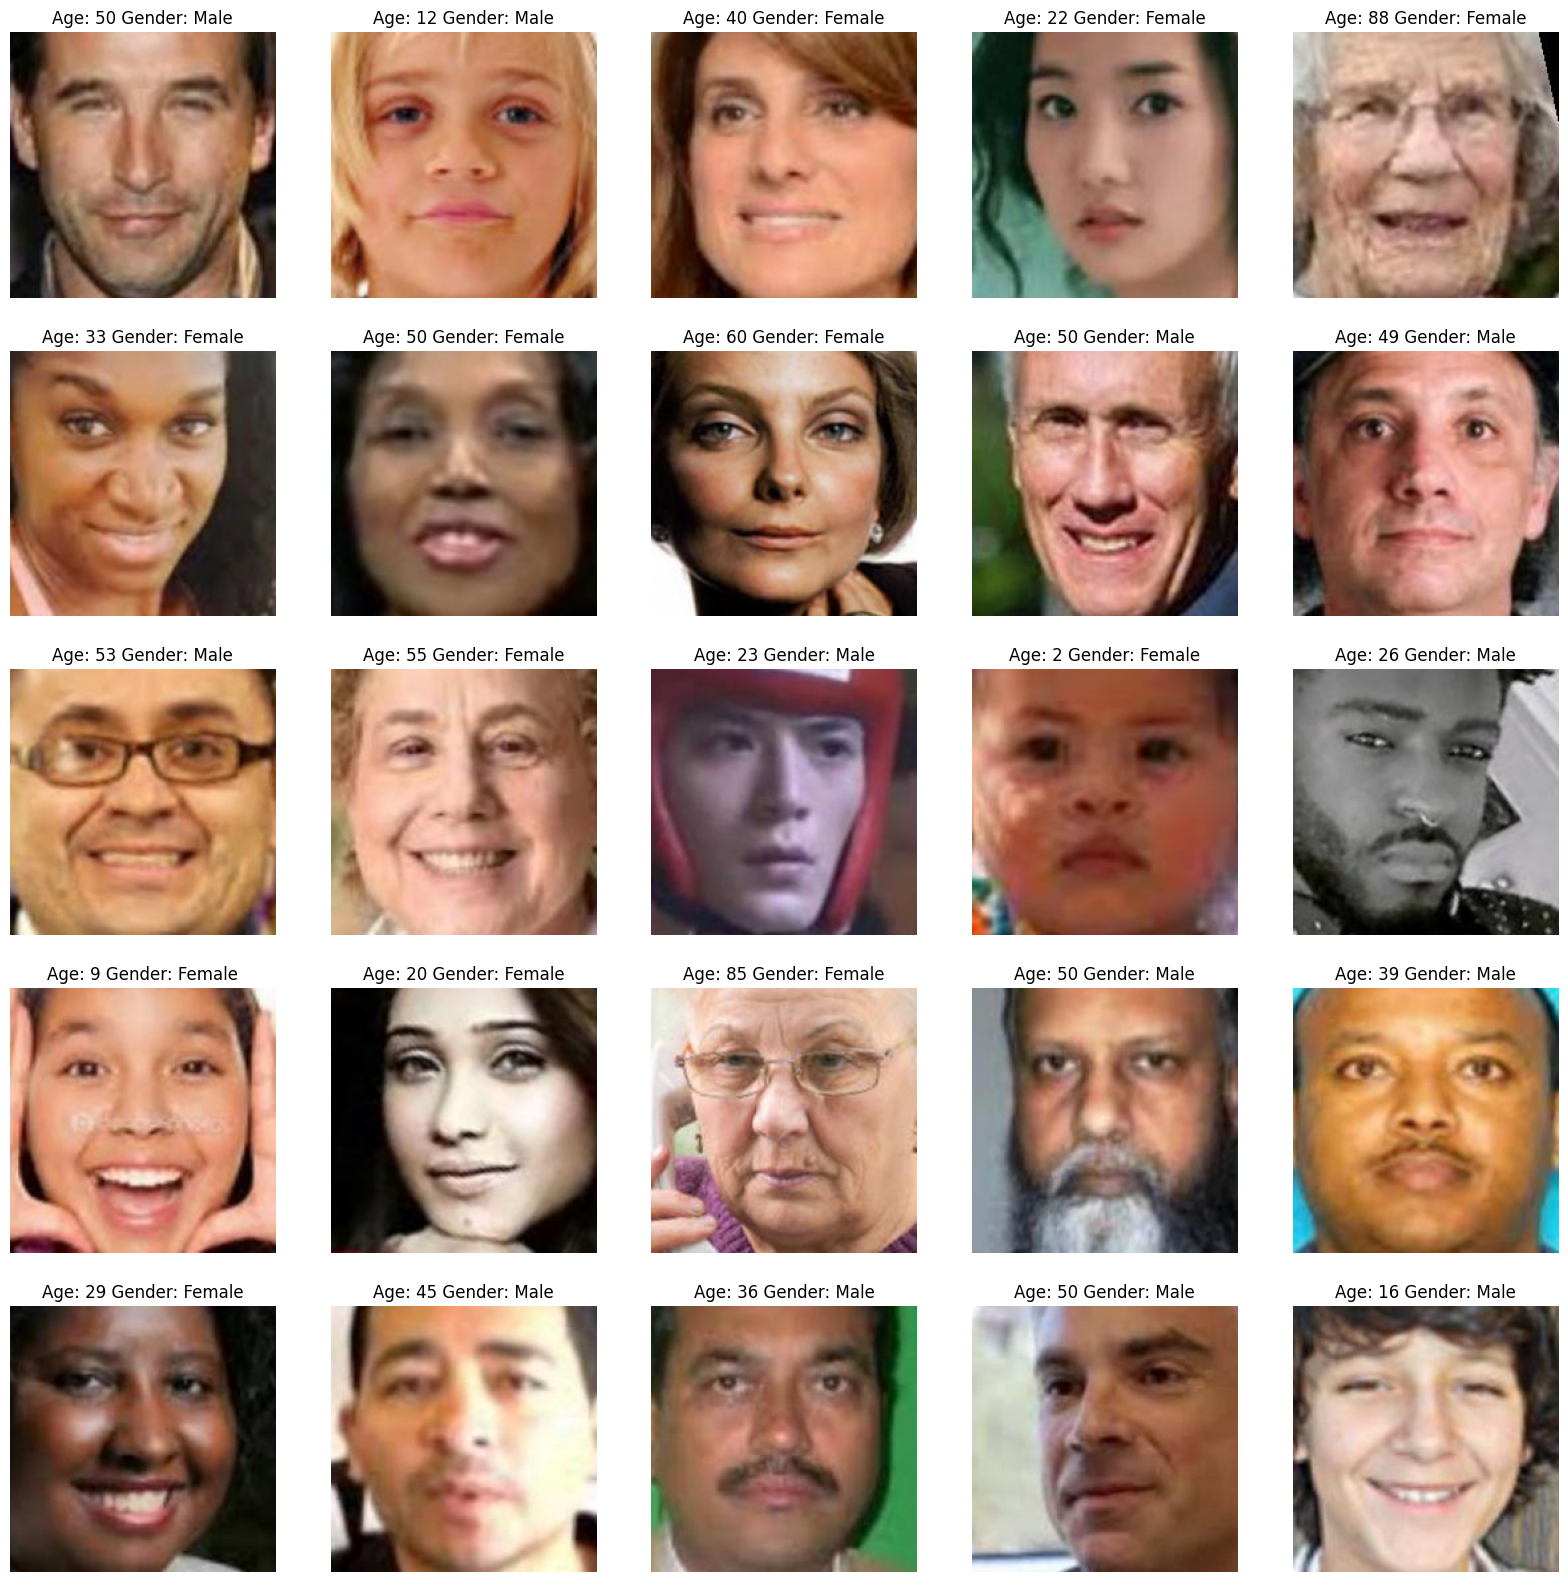

In [11]:
# to display grid of images
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

## Feature Extraction

In [12]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [13]:
X = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [14]:
X.shape

(23708, 128, 128, 1)

In [15]:
# normalize the images
X = X/255.0

In [16]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [17]:
input_shape = (128, 128, 1)

## Model Creation

In [18]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.4) (dense_1)
dropout_2 = Dropout(0.4) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy', 'mae'])

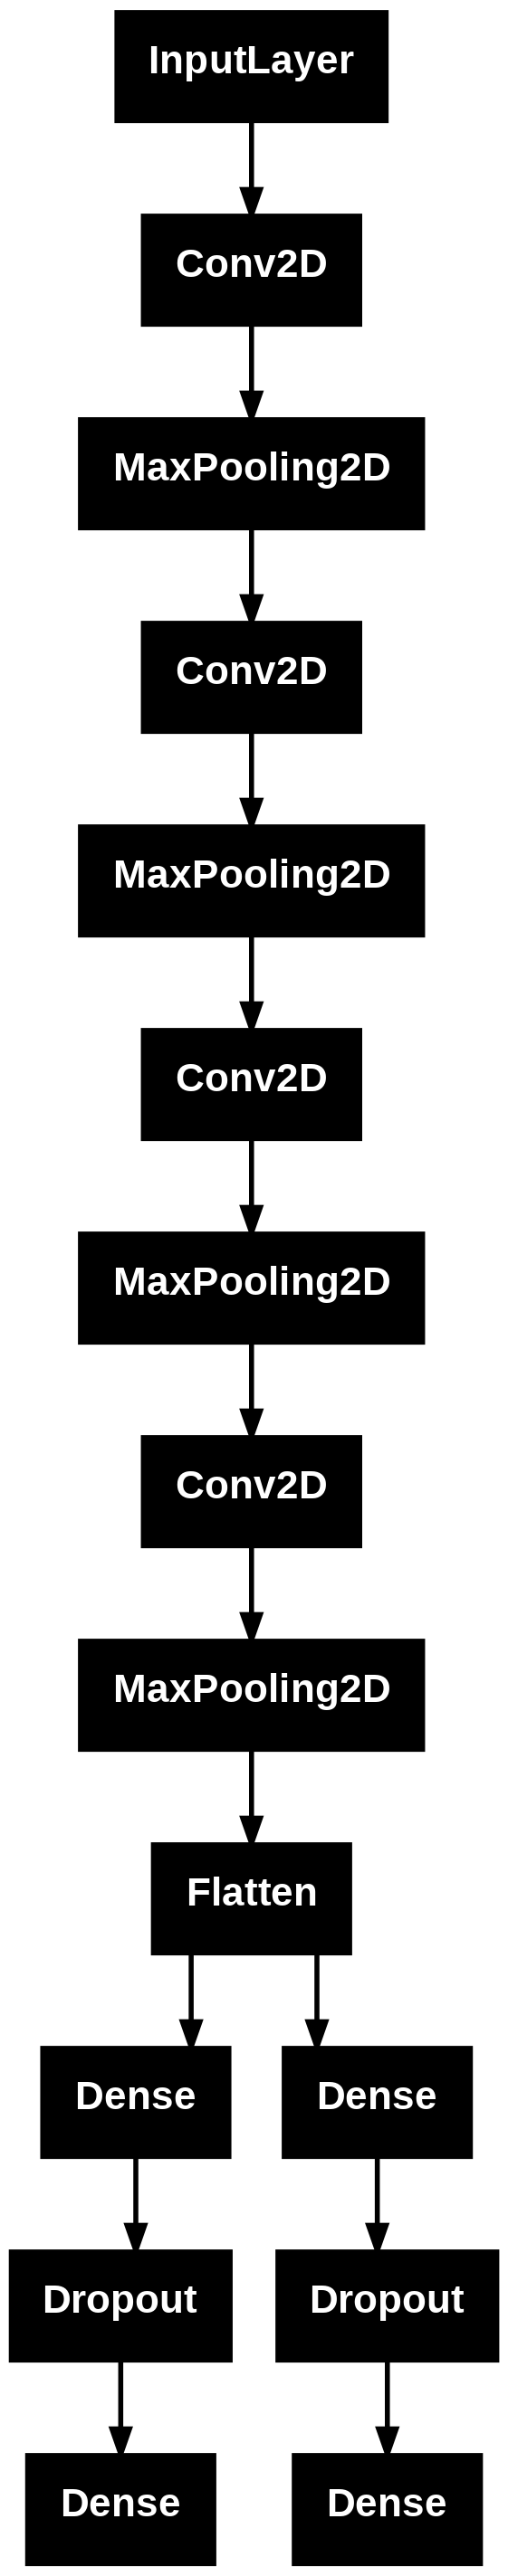

In [19]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [20]:
# train model
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=15, validation_split=0.2)

Epoch 1/15
593/593 ━━━━━━━━━━━━━━━━━━━━ 29s 32ms/step - age_out_mae: 16.5490 - gender_out_accuracy: 0.5219 - loss: 17.2535 - val_age_out_mae: 11.4487 - val_gender_out_accuracy: 0.7265 - val_loss: 11.9882
Epoch 2/15
593/593 ━━━━━━━━━━━━━━━━━━━━ 28s 21ms/step - age_out_mae: 11.6475 - gender_out_accuracy: 0.7316 - loss: 12.1846 - val_age_out_mae: 9.7254 - val_gender_out_accuracy: 0.7942 - val_loss: 10.1870
Epoch 3/15
593/593 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - age_out_mae: 9.8605 - gender_out_accuracy: 0.7894 - loss: 10.3144 - val_age_out_mae: 8.1863 - val_gender_out_accuracy: 0.8208 - val_loss: 8.5822
Epoch 4/15
593/593 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - age_out_mae: 8.7172 - gender_out_accuracy: 0.8182 - loss: 9.1122 - val_age_out_mae: 8.0939 - val_gender_out_accuracy: 0.8404 - val_loss: 8.4381
Epoch 5/15
593/593 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - age_out_mae: 7.9643 - gender_out_accuracy: 0.8428 - loss: 8.3108 - val_age_out_mae: 8.5127 - val_gender_out_accuracy: 0.8568 - val_loss:

## Plot the Results

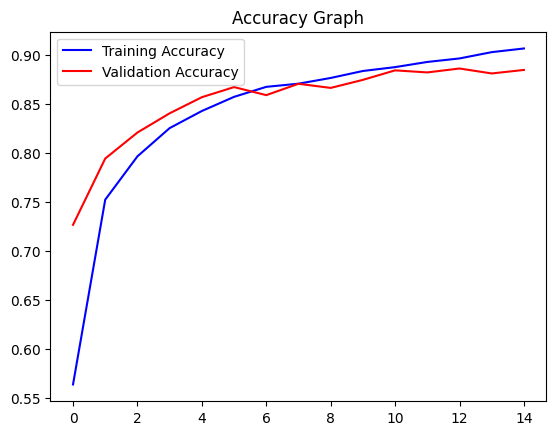

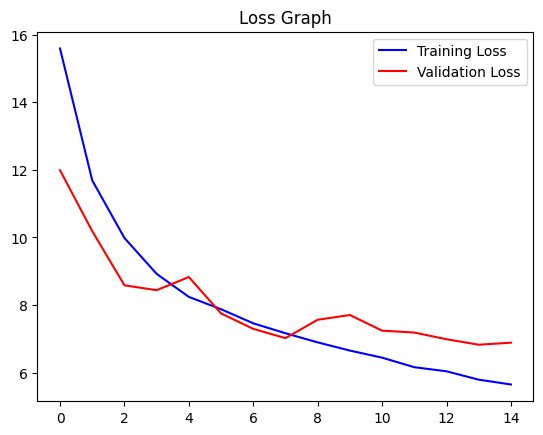

In [21]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

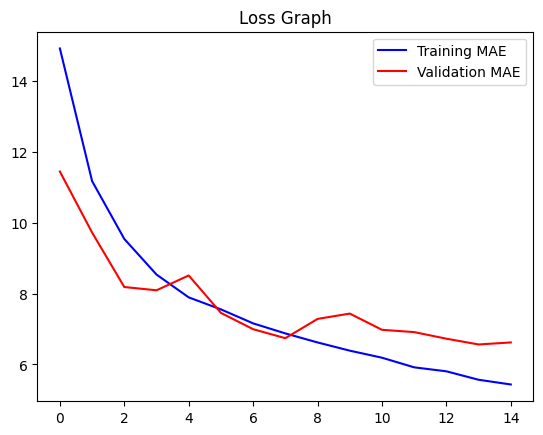

In [22]:
# plot results for age
loss = history.history['age_out_mae']
val_loss = history.history['val_age_out_mae']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training MAE')
plt.plot(epochs, val_loss, 'r', label='Validation MAE')
plt.title('Loss Graph')
plt.legend()
plt.show()

# Prediction with Test Data

Original Gender: Male Original Age: 40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step
Predicted Gender: Male Predicted Age: 43


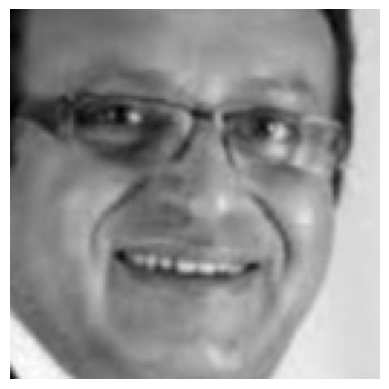

In [23]:
image_index = 100
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted Gender: Male Predicted Age: 60


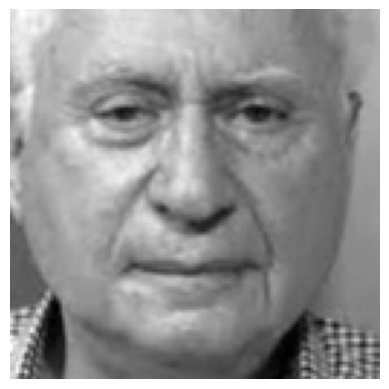

In [24]:
image_index = 3000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted Gender: Male Predicted Age: 81


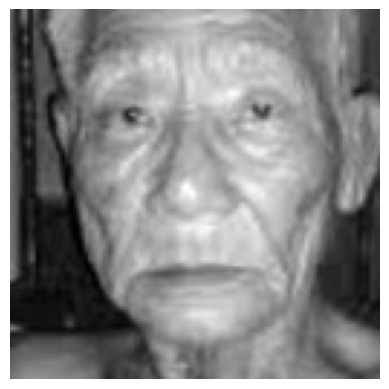

In [25]:
image_index = 10000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

# Prediction with New Data

Saving 50yrs_male_1.webp to 50yrs_male_1.webp
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted Gender: Male Predicted Age: 50


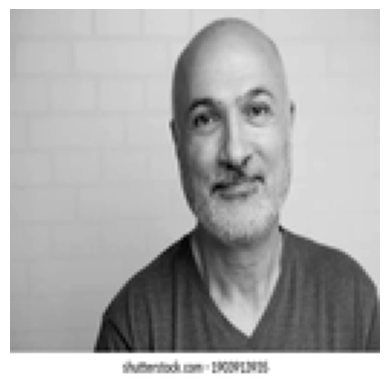

In [30]:


from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  # predicting images
  path = '/content/' + fn
  img = load_img(path, color_mode='grayscale')
  img = img.resize((128, 128), Image.ANTIALIAS)
  img_array = np.array(img)
  img_array = img_array.reshape(1, 128, 128, 1)
  img_array = img_array / 255.0
  pred = model.predict(img_array)
  pred_gender = gender_dict[round(pred[0][0][0])]
  pred_age = round(pred[1][0][0])
  print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
  plt.axis('off')
  plt.imshow(img_array.reshape(128, 128), cmap='gray');


Saving 60yrs_man_2.webp to 60yrs_man_2.webp
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted Gender: Male Predicted Age: 61


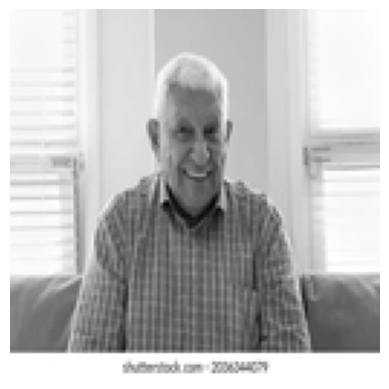

In [32]:


from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  # predicting images
  path = '/content/' + fn
  img = load_img(path, color_mode='grayscale')
  img = img.resize((128, 128), Image.ANTIALIAS)
  img_array = np.array(img)
  img_array = img_array.reshape(1, 128, 128, 1)
  img_array = img_array / 255.0
  pred = model.predict(img_array)
  pred_gender = gender_dict[round(pred[0][0][0])]
  pred_age = round(pred[1][0][0])
  print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
  plt.axis('off')
  plt.imshow(img_array.reshape(128, 128), cmap='gray');


Saving 45yrs_female.webp to 45yrs_female.webp
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted Gender: Female Predicted Age: 40


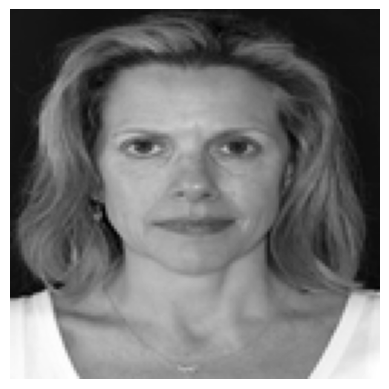

In [41]:


from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  # predicting images
  path = '/content/' + fn
  img = load_img(path, color_mode='grayscale')
  img = img.resize((128, 128), Image.ANTIALIAS)
  img_array = np.array(img)
  img_array = img_array.reshape(1, 128, 128, 1)
  img_array = img_array / 255.0
  pred = model.predict(img_array)
  pred_gender = gender_dict[round(pred[0][0][0])]
  pred_age = round(pred[1][0][0])
  print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
  plt.axis('off')
  plt.imshow(img_array.reshape(128, 128), cmap='gray');


Saving 15yrs_female.webp to 15yrs_female (1).webp
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted Gender: Female Predicted Age: 16


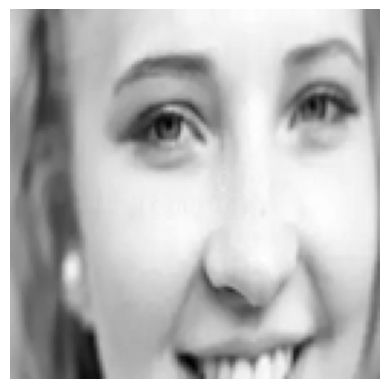

In [43]:


from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  # predicting images
  path = '/content/' + fn
  img = load_img(path, color_mode='grayscale')
  img = img.resize((128, 128), Image.ANTIALIAS)
  img_array = np.array(img)
  img_array = img_array.reshape(1, 128, 128, 1)
  img_array = img_array / 255.0
  pred = model.predict(img_array)
  pred_gender = gender_dict[round(pred[0][0][0])]
  pred_age = round(pred[1][0][0])
  print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
  plt.axis('off')
  plt.imshow(img_array.reshape(128, 128), cmap='gray');


Saving demo_0.jpg to demo_0.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted Gender: Male Predicted Age: 17


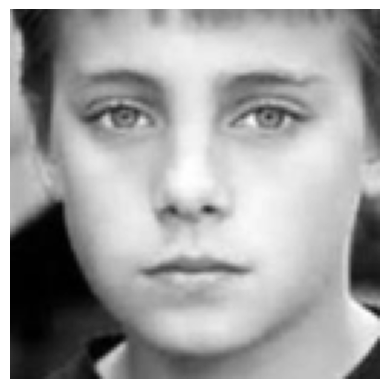

In [46]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  # predicting images
  path = '/content/' + fn
  img = load_img(path, color_mode='grayscale')
  img = img.resize((128, 128), Image.ANTIALIAS)
  img_array = np.array(img)
  img_array = img_array.reshape(1, 128, 128, 1)
  img_array = img_array / 255.0
  pred = model.predict(img_array)
  pred_gender = gender_dict[round(pred[0][0][0])]
  pred_age = round(pred[1][0][0])
  print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
  plt.axis('off')
  plt.imshow(img_array.reshape(128, 128), cmap='gray');
